In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import MDAnalysis as mda
import yaml
import pandas as pd
from string import Template
from pycomplexes import convert
import itertools

Use a system of Argon beads for an npt-Simulation. In this test we check that the correct density 
if reprocued for a given pressure. This is based on the npt tutorial!

# Reference Data

In this tutorial, we set up a NPT-Simlation with a number Ar-Atoms. Every particle acts symbolic as a domain for complexes and is simulated as an independent simulation bead.
In the following you will be provided reference data for a system of Ar-particles.
This system is a basic example of a lennard-jones fluid.

In [1]:
rho = [0.0025, 0.0059, 0.0102, 0.0128, 0.0153, 0.0178, 0.0204, 0.0229]
p = [74.60, 138.12, 295.96, 448.77, 737.1768776714837, 1269.49, 2216.57, 3816.02]
reference = pd.DataFrame({'rho':rho,'p':p})

[Text(0,0.5,'Density [$1/\\AA$]'), Text(0.5,0,'Pressure [bar]')]

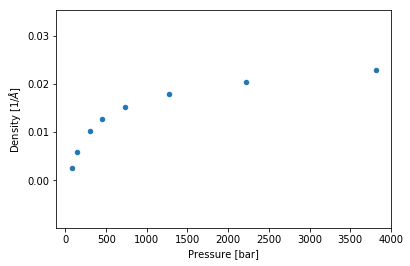

In [3]:
ax = reference.plot(x='p',y='rho',kind='scatter')
ax.set(xlabel='Pressure [bar]', ylabel='Density [$1/\AA$]')

In [10]:
pressure = 75  # Bar
n_beads = 125

In [11]:
initial_density = 0.01

# Prepare initial configuration

These are helper functions to create an initial configuration with all Argon beads placed on a regular grid.

In [5]:
def make_universe(nbeads):
    """Create MDAnalysis Universe from scratch for manipulation
    """
    u = mda.Universe.empty(nbeads, trajectory=True,
                           n_residues=nbeads,
                           atom_resindex=np.arange(nbeads),
                           n_segments=nbeads,
                           residue_segindex=np.arange(nbeads))
    u.add_TopologyAttr('names', np.array(['A', ] * nbeads))
    u.add_TopologyAttr('resnames', np.array(['AR',]*nbeads))
    u.add_TopologyAttr('resids', np.arange(nbeads) + 1)
    u.add_TopologyAttr('masses', np.ones(nbeads))
    u.add_TopologyAttr('segids', np.array(['A', ] * nbeads))
    u.add_TopologyAttr('altLocs')
    u.add_TopologyAttr('occupancies', np.ones(nbeads))
    u.add_TopologyAttr('icodes')
    u.add_TopologyAttr('tempfactors')
    return u

In [6]:
def density_to_volume(rho, N): # will be in same unit as (1/rho)^3
    """Calculate ocupied volume for a given density and number of particles"""
    return float(N) / rho

In [7]:
def is_cube(n):
    cube = np.round(np.cbrt(n))
    return cube**3 == n

def grid_points(n, boxsize):
    """equally distance points in a 3D grid
    """
    if not is_cube(n):
        raise ValueError('only works if n is a power of 3')
    
    L = .9 * boxsize
    # how many points can I put along once axis
    points_per_dim = int(np.round(np.cbrt(n)))
    dx = L / (points_per_dim - 1)
    
    # generate grid points here
    points = [np.array(ijk) * dx for ijk in itertools.product(range(points_per_dim), repeat=3)]
    return np.array(points) 

In [8]:
top_tmpl = Template("""
box: [$box, $box, $box]
topology:
    Argon:
        coordinate-file: $fname
        domains: None
""")

dom_tmpl = Template("""
    selection : resnum $i
    type: rigid
""")

def create_initial_cplx(nbeads, density, fname='ar-sys'):
    """Create initial cplx system
    """
    box_volume = density_to_volume(density, nbeads)
    box_length = np.cbrt(box_volume)
    box = np.ones(3) * box_length

    u = make_universe(nbeads)
    u.atoms.positions = grid_points(nbeads, box_length)
    pdb = fname + '.pdb'
    u.atoms.write(pdb)
    
    doms = {'AR-{}'.format(i): yaml.load(dom_tmpl.substitute(i=i)) for i in range(1, nbeads+1)}
    top =  yaml.load(top_tmpl.substitute(box=box_length, fname=pdb))
    top['topology']['Argon']['domains'] = doms
    
    
    with open(fname + '.cplx', 'w') as fh:
        yaml.dump(convert.convert(top, random=False, forcefield='argon.yaml'), fh)

Now you can create an initial configuration for your Simulation in a format that complexes can interpret `ar-sys.cplx`.


In [12]:
create_initial_cplx(n_beads, initial_density)

In [13]:
initial_density

0.01

# create npt-config


Before you can start the Simulation you need to create a file, that contains all the information, that complexes needs to perform an NPT-Simulation. We now create our configuration file for the simulation. As the maximal delta for the volume moves  we use 10 % of the initial volume. We also set some other parameters for our simulation.

In [15]:
dV = .1 * density_to_volume(initial_density, n_beads)
print("dV = ", dV)
print("pressure = ", pressure)
nstructures = 2000 # increase for better sampling

dV =  1250.0
pressure =  75


In [16]:
config_tmp = Template("""
structure: ar-sys.cplx
montecarlo:
  algorithm: npt
  algorithm-params: 
    accept-func: metropolis
    dV: $dV
    pressure: $pressure
    temperatur: 240
  equilibration: 0
  initial-position: {strategy: ignore}
  seed: 1539172181
  short-range-cutoff: {enable: false}
output: 
  file: npt.xtc
  freq: 10
  log: npt-log
  nstructures: $nstructures
  restart-freq: -1
  stat-file: npt.stat
""")

In [17]:
with open('npt.conf', 'w') as fh:
    fh.write(config_tmp.substitute(pressure=pressure,
                                   dV=dV,
                                   nstructures=nstructures))

You have now created the file npt.conf and therefore everything you need to start your npt-simulation with complexes

# run NPT Simulation

In [18]:
!complexes++ --config=npt.conf 2> /dev/null

^C


# screen volume

Since we are particularly interested in the behaviour of the volume of our system, we want to extract the volume of the system over the simulation.
The following function uses MDAnalysis to do so.

In [17]:
stat = pd.read_csv('npt.stat')
volume = stat.volume

[Text(0,0.5,'volume'), Text(0.5,0,'frames')]

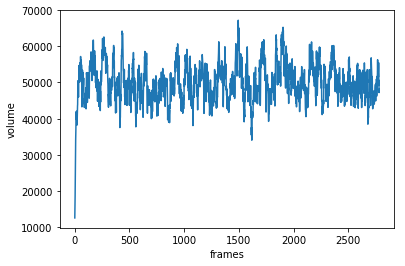

In [21]:
f,axs = plt.subplots()
axs.plot(volume)
axs.set(xlabel ='frames', ylabel='volume')

In [22]:
def volume_to_density(vol, nbeads):
    return nbeads / float(vol)

In [23]:
mean_vol = volume[1000:].mean()

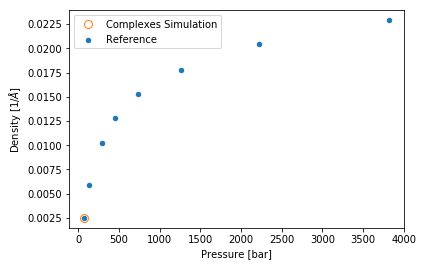

In [35]:
fig, ax = plt.subplots()
ax.plot([pressure,], [volume_to_density(mean_vol, n_beads)], 'o', markersize=8,
        label='Complexes Simulation', c='none', zorder=1, markeredgecolor='C1')


ax = reference.plot(x='p',y='rho',kind='scatter', label='Reference',ax=ax, zorder=2)
ax.set(xlabel='Pressure [bar]', ylabel='Density [$1/\AA$]')

ax.legend();